In [1]:
import warnings

warnings.filterwarnings("ignore")

# Regresión Espacial

La regresión proporciona un caso perfecto para examinar cómo la estructura espacial puede ayudar a comprender y analizar los datos. En este taller, se analiza cómo se puede utilizar la estructura espacial para validar y mejorar los algoritmos de predicción, centrándose específicamente en la regresión lineal.

## *¿Qué* es la regresión espacial y *por qué* podría ser importante?

Por lo general, la estructura espacial ayuda a los modelos de regresión de dos maneras.

La primera forma en la que el espacio puede tener un impacto en los datos es cuando el proceso *que genera* los datos es en sí mismo explícitamente espacial. Se puede pensar en algo así como los precios de las viviendas unifamiliares. A menudo ocurre que las personas pagan una prima sobre el precio de su casa para poder vivir en un mejor distrito escolar por una casa de la misma calidad. Alternativamente, las casas más cercanas a contaminantes acústicos o químicos, como plantas de tratamiento de aguas residuales, instalaciones de reciclaje o autopistas anchas, pueden en realidad ser más baratas de lo que se anticiparía.

Independientemente del caso específico en juego, aquí la *geografía es una característica* dado que ayuda directamente a hacer predicciones sobre los resultados *porque esos resultados se obtienen a partir de procesos geográficos*.

Otra alternativa para incluir información en el análisis de métodos predictivos y clasificadores, a un analista le puede preocupar que el modelo prediga erróneamente *sistemáticamente* algunos tipos de observaciones. Si se sabe que el modelo rutinariamente funciona mal en un conjunto de observaciones, se podría hacer un modelo mejor si se puede identificar esto. 

 La geografía proporciona una incorporación excepcionalmente útil para evaluar la estructura de nuestros errores. Graficar los errores de clasificación/predicción en un mapa puede ayudar a mostrar si hay o no *grupos de errores* en los datos. Si *se sabe* que los errores tienden a ser mayores en algunas áreas que en otras (o si el error es "contagioso" entre observaciones), entonces se podría explotar esta estructura para hacer mejores predicciones.

La estructura espacial en nuestros errores puede surgir cuando la geografía *debería ser* un atributo de alguna manera, pero no se está seguro exactamente de cómo incluirla en el modelo. También podrían surgir porque hay alguna *otra* característica cuya omisión causa los patrones espaciales en el error que se observa, si se incluyera esta característica adicional, la estructura desaparecería.

O podría surgir de las complejas interacciones e interdependencias entre las características que se han elegido como predictores, lo que da como resultado una estructura intrínseca en la predicción errónea.  La mayoría de los predictores que se utilizan en modelos de procesos sociales contienen información espacial *incorporada*: patrones intrínsecos a la característica que obtenemos de forma gratuita en el modelo.

Si se pretende o no, el uso de un predictor con patrones espaciales en un modelo puede dar como resultado errores con patrones espaciales, usar más de uno puede amplificar este efecto. 
Por lo tanto, *independientemente de si el verdadero proceso es explícitamente geográfico o no*, información adicional sobre las relaciones espaciales entre las observaciones o más información sobre sitios cercanos puede mejorar las predicciones.

En este taller, se incorpora el espacio al marco de regresión tradicional. Se comienza con un modelo de regresión lineal estándar, desprovisto de cualquier referencia geográfica. A partir de ahí, se formaliza el espacio y las relaciones espaciales de tres maneras principales: primero, codificándolo en variables exógenas, en segundo lugar, a través de la heterogeneidad espacial o como una variación sistemática de los resultados en el espacio, tercero, como dependencia, o mediante el efecto asociado a las características de los vecinos espaciales. En todo momento, centrándose en las diferencias conceptuales que implica cada enfoque más que en los detalles técnicos.

## Regresión clásica (no espacial), un repaso muy rápido

Antes de discutir cómo incluir explícitamente el espacio en el marco de regresión lineal, se muestra cómo se puede llevar a cabo la regresión básica en Python y cómo se pueden comenzar a interpretar los resultados.

La idea central de la regresión lineal es explicar la variación en una variable dada (*dependiente*) como una función lineal de un conjunto de otras variables (*explicatorias*). Por ejemplo, en este caso, se puede querer expresar el precio de una casa en función del número de dormitorios que tiene y de si es condominio o no. A nivel individual, se puede expresar esto como:

$$
y_i = \alpha + \sum_k \beta_k \mathbf{X}_{ik}  + \epsilon_i
$$

Por ejemplo, en este caso, se puede querer expresar el precio de una casa en función del número de dormitorios que tiene y de si es condominio o no. A nivel individual, se puede expresar esto como:

$$
P_i = \alpha + \sum_k \beta_k \mathbf{X}_{ik}  + \epsilon_i
$$

Donde $P_i$ es el precio de Airbnb de la casa $i$, y $X$ es un conjunto de covariables que se usan para explicar dicho precio (por ejemplo, cantidad de habitaciones y variable binaria de condominio). $\beta$ es un vector de parámetros que nos dan información sobre de qué manera y en qué medida cada variable está relacionada con el precio, y $\alpha$, el término constante, es el precio medio de la vivienda cuando todas las demás variables son cero. El término $\epsilon_i$ generalmente se conoce como "error" y captura elementos que influyen en el precio de una casa pero que no están incluidos en $X$.

El objetivo cuando se entrena un modelo de regresión es estimar los parámetros $\alpha$ y $\beta_k$ para predecir los valores de $y$.

En la práctica, existen varios paquetes en Python que permiten entrenar modelos de regresión, algunos de estos son: `statsmodels`, `scikit-learn` y `pysal`.

## Dataset: San Diego Airbnb

En este taller se examinará información sobre propiedades de Airbnb en San Diego, California en Estados Unidos. Este conjunto de datos se basa en el extracto de San Diego del 2024-03-25 de [Inside Airbnb](http://insideairbnb.com/).

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path().cwd().parent.absolute() / "data/airbnb"

### Listado de propiedades:

In [3]:
# Listings

url = "https://data.insideairbnb.com/united-states/ca/san-diego/2024-03-25/data/listings.csv.gz"

listings_path = DATA_PATH / "listings.csv.gz"

response = requests.get(url)

with open(listings_path, "wb") as file:
    file.write(response.content)

### Vecindarios

In [4]:
# Neighbourhoods

url =  "https://data.insideairbnb.com/united-states/ca/san-diego/2024-03-25/visualisations/neighbourhoods.geojson"

neighbourhoods_path = DATA_PATH / "neighbourhoods.geojson"

response = requests.get(url)

with open(neighbourhoods_path, "wb") as file:
    file.write(response.content)

#### Feature engineering

In [5]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
listings_path = DATA_PATH / "listings.csv.gz"

df = pd.read_csv(listings_path)
df.shape

(11496, 75)

#### Columnas de interés:

* accommodates: Cantidad de personas que puede acoger
* amenities: Comodidades que ofrece el alojamiento
* bathrooms: Cantidad de baños
* bedrooms: Cantidad de cuantos
* beds: Cantidad de camas disponibles
* latitude: Latitud. World Geodetic System (WGS84). EPSG:4326
* longitude: Longitud. World Geodetic System (WGS84). EPSG:4326
* neighbourhood_cleansed: Vecindario
* price: Precio del alojamiento (variable objetivo)
* room_type: Tipo de habitación

In [7]:
df = df[
    [
        "accommodates",
        "amenities",
        "bathrooms",
        "bedrooms",
        "beds",
        "latitude",
        "longitude",
        "neighbourhood_cleansed",
        "price",
        "room_type",
    ]
].rename(columns={"neighbourhood_cleansed": "neighbourhood"})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11496 entries, 0 to 11495
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   accommodates   11496 non-null  int64  
 1   amenities      11496 non-null  object 
 2   bathrooms      11229 non-null  float64
 3   bedrooms       11449 non-null  float64
 4   beds           11203 non-null  float64
 5   latitude       11496 non-null  float64
 6   longitude      11496 non-null  float64
 7   neighbourhood  11496 non-null  object 
 8   price          11230 non-null  object 
 9   room_type      11496 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 898.3+ KB


APLICAR TODOS LOS FILTROS EN ESTA ETAPA: 

1. Eliminar todos las filas que tengan alguna columna con un valor nulo.
2. Quiero estudiar las propiedades que tengan por lo menos un baño, una habitación y ofrezcan por lo menos una cama.

In [8]:
df = df.dropna()
df = df[df["room_type"].isin(["Entire home/apt", "Private room"])]

#### Filtrar vecindarios con pocas observaciones

Los vecindarios con pocos datos pueden no proporcionar estadísticas confiables. Con más de 25 datos, es más probable que los estadísticos sean representativos.

In [9]:
neighborhood_counts = df["neighbourhood"].value_counts()
neighborhoods_to_keep = neighborhood_counts[neighborhood_counts > 25].index

df = df[
    df["neighbourhood"].isin(
        neighborhoods_to_keep
    )
].reset_index(drop=True)

df.shape

(10592, 10)

#### Variable objetivo: Precio

In [10]:
df["price"].head(10)

0    $274.00
1    $231.00
2    $163.00
3     $87.00
4    $102.00
5    $179.00
6     $71.00
7    $226.00
8    $914.00
9    $811.00
Name: price, dtype: object

In [11]:
df["price"] = df["price"].str.lstrip("$").str.replace(",", "").astype(float)

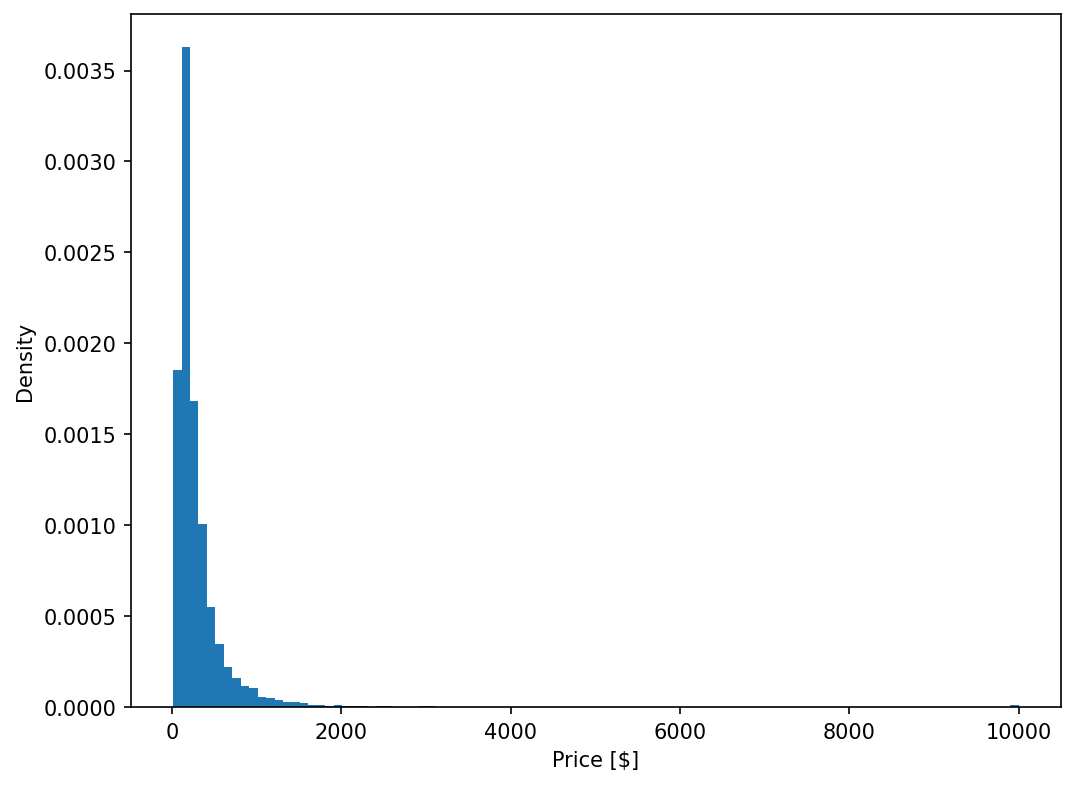

In [12]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist(df["price"], density=True, bins=100)
ax.set(
    ylabel="Density",
    xlabel="Price [$]"
)
plt.show()

En Machine Learning, se suelen transformar las variables para normalizar datos, reducir el impacto de valores atípicos y hacer que los datos sean más adecuados para ciertos tipos de análisis. En este caso, se aplica una transformación logarítmica para reducir la escala del precio.

In [13]:
df["log_price"] = np.log(df["price"])

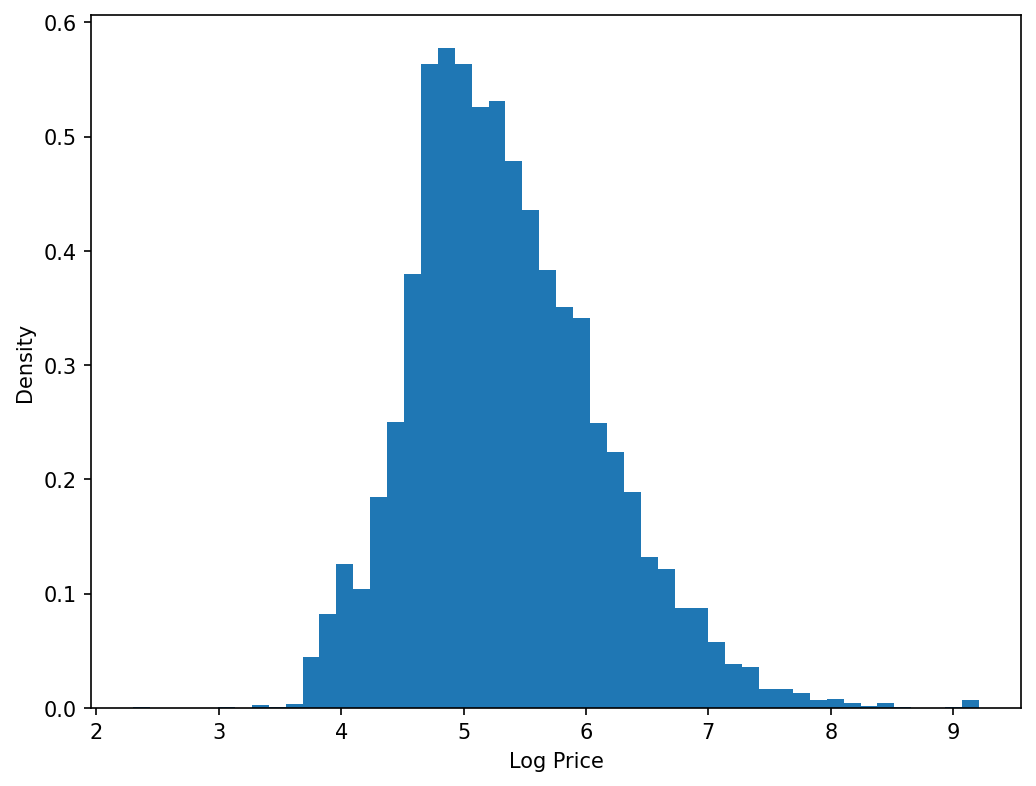

In [14]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist(df["log_price"], density=True, bins=50)
ax.set(
    ylabel="Density",
    xlabel="Log Price"
)
plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10592 entries, 0 to 10591
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   accommodates   10592 non-null  int64  
 1   amenities      10592 non-null  object 
 2   bathrooms      10592 non-null  float64
 3   bedrooms       10592 non-null  float64
 4   beds           10592 non-null  float64
 5   latitude       10592 non-null  float64
 6   longitude      10592 non-null  float64
 7   neighbourhood  10592 non-null  object 
 8   price          10592 non-null  float64
 9   room_type      10592 non-null  object 
 10  log_price      10592 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 910.4+ KB


### Primer modelo de regresión

En este taller se hace uso del módulo `spreg` en Pysal. Se usa esta librería puesto que la única que permitiría avanzar hacia modelos espaciales.

Para ajustar el modelo usando mínimos cuadrados ordinarios (OLS), sólo se necesita la siguiente línea de código.

Es importante mencionar que los objectos necesitan ser arrays, por lo que lo que se extrae usando el atributo `values`.

In [16]:
from pysal.model import spreg

In [17]:
variables = [
    "accommodates",
]

y = df["log_price"]

X = df[variables]

In [18]:
# Fit OLS model
model_1 = spreg.OLS(
    y.values,
    X.values,
    name_y="log_price",
    name_x=variables,
)

Para inspeccionar los resultados del modelo, se puede hacer un print el atributo `summary`:

In [19]:
print(model_1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       10592
Mean dependent var  :      5.3546                Number of Variables   :           2
S.D. dependent var  :      0.7746                Degrees of Freedom    :       10590
R-squared           :      0.5253
Adjusted R-squared  :      0.5253
Sum squared residual:     3016.53                F-statistic           :  11720.8463
Sigma-square        :       0.285                Prob(F-statistic)     :           0
S.E. of regression  :       0.534                Log likelihood        :   -8377.666
Sigma-square ML     :       0.285                Akaike info criterion :   16759.332
S.E of regression ML:      0.5337                Schwarz criterion     :   16773.867

------------------------------------------------------------

De este resultado, es importante concentrarse en la sección `Coefficients`, que brinda las estimaciones de $\beta_k$ en el modelo. En otras palabras, estos números expresan la relación entre cada variable explicativa y la dependiente.

Este resultado es esperado. Las propiedades tienden a ser más caras si tienen capacidad para más personas.

En general, el modelo puede predecir menos de la mitad ($R^2=0,52$) de la variación en el precio medio nocturno utilizando la covariable que se analizó.

# Ejercicio 1

a) Entrenar otro modelo de regresión usando la cantidad de habitaciones.

### ¿Se puede mejorar?

Se incluyen nuevas variables para intentar mejorar el modelo.

#### Tipo de alquiler: ¿Se alquila una propiedad completa?

In [20]:
df["is_entire_place"] = (df["room_type"] == "Entire home/apt").astype(int)

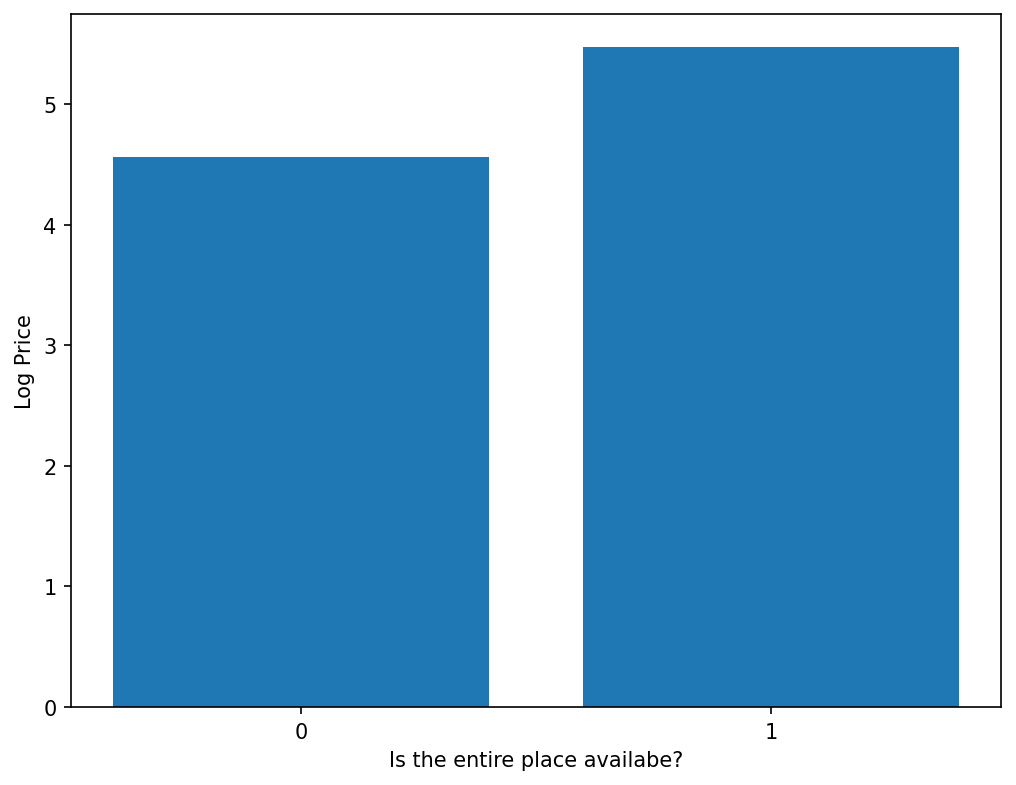

In [21]:
# Average price
avg_price = df.groupby("is_entire_place")["log_price"].mean().reset_index()

is_entire_place = avg_price["is_entire_place"]
prices = avg_price["log_price"]

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Crear el gráfico de barras en los ejes
ax.bar(is_entire_place, prices)

# Agregar título y etiquetas
ax.set_xlabel("Is the entire place availabe?")
ax.set_ylabel("Log Price")
ax.set_xticks(is_entire_place, [0, 1])

plt.show()

#### Amenities: ¿Tiene lavaplatos / lavavajillas?

In [22]:
for amenity in df["amenities"].unique()[:1]:
    print(amenity)

["Free dryer \u2013 In unit", "Cooking basics", "Children\u2019s dinnerware", "Laundromat nearby", "Oven", "Coffee", "Ethernet connection", "Fire pit", "Baby monitor", "Blender", "Children's playroom", "Wine glasses", "Private backyard \u2013 Fully fenced", "Central air conditioning", "Dishes and silverware", "Private entrance", "Bed linens", "Smoke alarm", "Coffee maker: Keurig coffee machine, pour-over coffee", "Toaster", "Wifi", "Free parking on premises", "Ceiling fan", "Luggage dropoff allowed", "Cleaning products", "Shower gel", "Children\u2019s bikes", "Portable fans", "Extra pillows and blankets", "Children\u2019s books and toys", "Self check-in", "Essentials", "Iron", "Microwave", "First aid kit", "75\" HDTV with Amazon Prime Video, Apple TV, Disney+, HBO Max, Hulu, Netflix", "Pack \u2019n play/Travel crib - available upon request", "Dishwasher", "Freezer", "Heating", "Hot water", "Barbecue utensils", "Bathtub", "Hair dryer", "Books and reading material", "Pets allowed", "Crib

In [23]:
# Convert string in lists
df["amenities"] = df["amenities"].apply(json.loads)

In [24]:
df["amenities"][0]

['Free dryer – In unit',
 'Cooking basics',
 'Children’s dinnerware',
 'Laundromat nearby',
 'Oven',
 'Coffee',
 'Ethernet connection',
 'Fire pit',
 'Baby monitor',
 'Blender',
 "Children's playroom",
 'Wine glasses',
 'Private backyard – Fully fenced',
 'Central air conditioning',
 'Dishes and silverware',
 'Private entrance',
 'Bed linens',
 'Smoke alarm',
 'Coffee maker: Keurig coffee machine, pour-over coffee',
 'Toaster',
 'Wifi',
 'Free parking on premises',
 'Ceiling fan',
 'Luggage dropoff allowed',
 'Cleaning products',
 'Shower gel',
 'Children’s bikes',
 'Portable fans',
 'Extra pillows and blankets',
 'Children’s books and toys',
 'Self check-in',
 'Essentials',
 'Iron',
 'Microwave',
 'First aid kit',
 '75" HDTV with Amazon Prime Video, Apple TV, Disney+, HBO Max, Hulu, Netflix',
 'Pack ’n play/Travel crib - available upon request',
 'Dishwasher',
 'Freezer',
 'Heating',
 'Hot water',
 'Barbecue utensils',
 'Bathtub',
 'Hair dryer',
 'Books and reading material',
 'Pets a

In [25]:
df["has_dishwasher"] = df["amenities"].apply(
    lambda x: any("dishwasher" in amenity.lower() for amenity in x)
).astype(int)

In [26]:
print(f"Number of properties with dishwaher: {df['has_dishwasher'].sum()}")

Number of properties with dishwaher: 6078


In [27]:
df["has_dishwasher"].mean()

0.5738293051359517

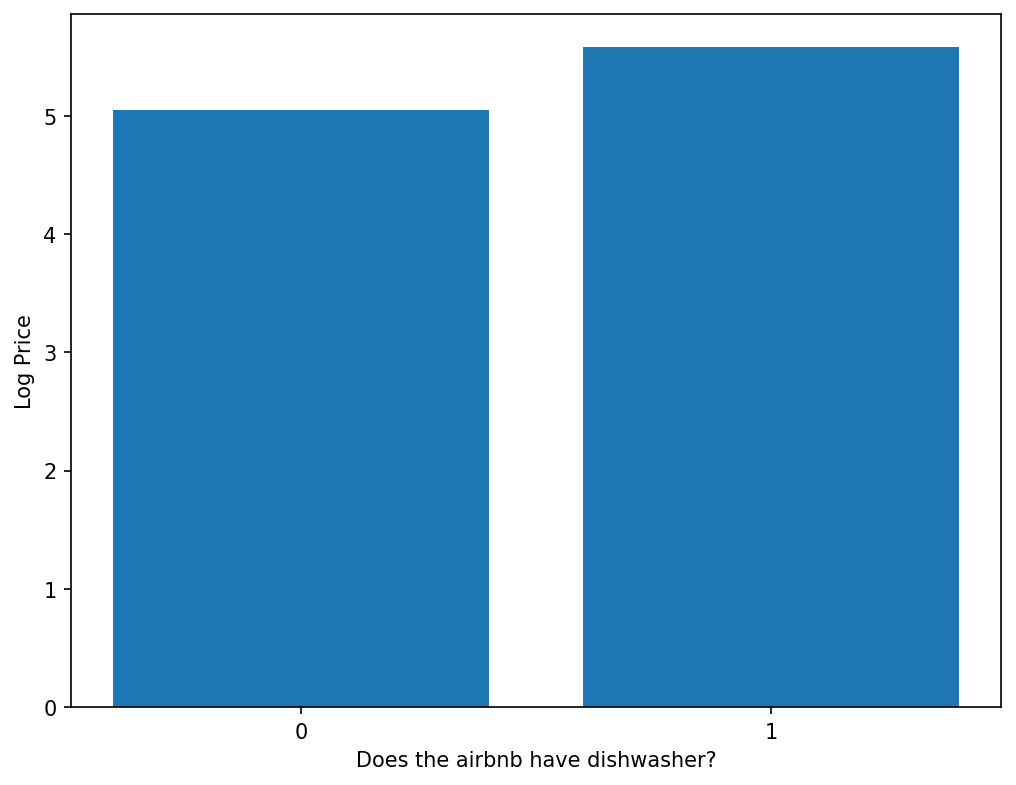

In [28]:
# Average price
avg_price = df.groupby("has_dishwasher")["log_price"].mean().reset_index()

has_dishwasher = avg_price["has_dishwasher"]
prices = avg_price["log_price"]

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Crear el gráfico de barras en los ejes
ax.bar(has_dishwasher, prices)

# Agregar título y etiquetas
ax.set_xlabel("Does the airbnb have dishwasher?")
ax.set_ylabel("Log Price")
ax.set_xticks(has_dishwasher, [0, 1])

plt.show()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10592 entries, 0 to 10591
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   accommodates     10592 non-null  int64  
 1   amenities        10592 non-null  object 
 2   bathrooms        10592 non-null  float64
 3   bedrooms         10592 non-null  float64
 4   beds             10592 non-null  float64
 5   latitude         10592 non-null  float64
 6   longitude        10592 non-null  float64
 7   neighbourhood    10592 non-null  object 
 8   price            10592 non-null  float64
 9   room_type        10592 non-null  object 
 10  log_price        10592 non-null  float64
 11  is_entire_place  10592 non-null  int64  
 12  has_dishwasher   10592 non-null  int64  
dtypes: float64(7), int64(3), object(3)
memory usage: 1.1+ MB


# Ejercicio 2

Agregar una nueva variable llamada has_bathtub dependiendo de si la propiedad tiene Bathtub o no.

### Segundo modelo de regresión

In [30]:
variables = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "has_dishwasher",
    "is_entire_place",
]

y = df["log_price"]

X = df[variables]

In [31]:
# Fit OLS model
model_2 = spreg.OLS(
    y.values,
    X.values,
    name_y="log_price",
    name_x=variables,
)

In [32]:
print(model_2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       10592
Mean dependent var  :      5.3546                Number of Variables   :           7
S.D. dependent var  :      0.7746                Degrees of Freedom    :       10585
R-squared           :      0.5954
Adjusted R-squared  :      0.5952
Sum squared residual:     2571.35                F-statistic           :   2596.0364
Sigma-square        :       0.243                Prob(F-statistic)     :           0
S.E. of regression  :       0.493                Log likelihood        :   -7532.014
Sigma-square ML     :       0.243                Akaike info criterion :   15078.029
S.E of regression ML:      0.4927                Schwarz criterion     :   15128.904

------------------------------------------------------------

Los resultados son en gran medida los esperados: las casas tienden a ser significativamente más caras si se alquila toda la propiedad, tienen capacidad para más personas (`accommodates`), si tienen más baños, dormitorios o lavajillas. Por el contrario, dado el número de habitaciones, las casas con más camas (es decir, las que están más "pobladas") tienden a ser más baratas.

En general, el modelo puede predecir alrededor de la mitad ($R^2=0,60$) de la variación en el precio medio nocturno utilizando las covariables que se han analizado anteriormente.

Sin embargo, el modelo puede mostrar cierta agrupación en los errores, lo que puede ser un problema ya que viola la norma i.i.d. que los modelos lineales de suposición generalmente vienen incorporados.

Una teoría razonable podría ser que el modelo no incluye ninguna información sobre *playas*, un aspecto crítico de por qué la gente vive y vacaciona en San Diego. Por lo tanto, es posible que se desee ver si los errores son mayores o menores dependiendo de si un Airbnb está o no en un vecindario "de playa", un vecindario cerca del océano.

In [33]:
coastal_neighborhoods = [
    "Wooded Area",
    "Ocean Beach",
    "Pacific Beach",
    "La Jolla",
    "Torrey Pines",
    "Del Mar Heighs",
    "Mission Bay",
]

# Create a Boolean (True/False) with whether a property is coastal or not
df["is_coastal_neig"] = (
    df["neighbourhood"].isin(coastal_neighborhoods).astype(bool)
)

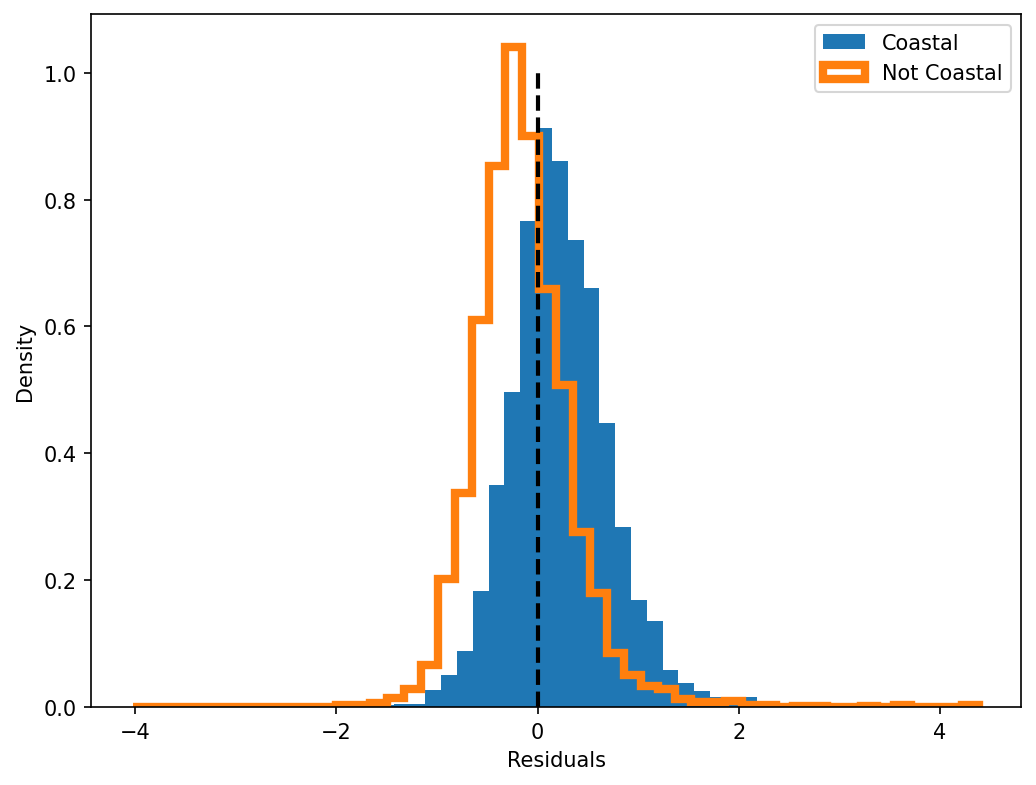

In [34]:
is_coastal_neig = df["is_coastal_neig"]

# Split residuals between coastal and not
coastal_residuals = model_1.u[is_coastal_neig]
non_coastal_residuals = model_1.u[~is_coastal_neig]

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Create histogram of the distribution of coastal and non-coastal residuals
ax.hist(coastal_residuals, density=True, bins=50, label="Coastal")
ax.hist(
    non_coastal_residuals,
    histtype="step",
    density=True,
    linewidth=4,
    bins=50,
    label="Not Coastal",
)
ax.set(ylabel="Density", xlabel="Residuals")

plt.vlines(0, 0, 1, linestyle="--", color="k", linewidth=2)
plt.legend()
plt.show()

Si bien parece que los vecindarios de la costa tienen errores promedio sólo ligeramente más altos, las dos distribuciones son significativamente distintas entre sí cuando se comparan utilizando una prueba $t$ clásica:

In [35]:
from scipy.stats import ttest_ind

ttest_ind(coastal_residuals, non_coastal_residuals)

TtestResult(statistic=array([36.50324659]), pvalue=array([6.7081738e-275]), df=array([10590.]))

## Trayendo el espacio al marco de regresión

Hay muchas formas en que la estructura espacial aparece en los modelos, predicciones y datos, incluso si no se tiene la intención explícita de modelarse.

Afortunadamente, existen técnicas llamadas métodos de *regresión espacial*, que están diseñadas para manejar este tipo de estructuras. La regresión espacial consiste en introducir *explícitamente* el espacio o el contexto geográfico en el marco estadístico de una regresión.

Conceptualmente, se introduce el espacio en el modelo siempre que se piense que este juega un papel importante en el proceso que interesa modelar, o cuando el espacio puede actuar como un sustituto razonable de otros factores que no se pueden pero se deberían incluir en el modelo.

# Ejercicio 3

Usando los datos disponibles en bank_location/guatemala.geojson representar gráficamente el mapa de guametemala. Usando crs = EPSG:4326

### Variables de proximidad

Se pueden incorporar *características espaciales* construidas a partir de relaciones geográficas.

Una variable relevante impulsada por la proximidad que podría influir en este modelo se basa en la proximidad de las propiedades al Parque Balboa. Un destino turístico común, es un centro recreativo central para la ciudad de San Diego, que contiene muchos museos y el Zoológico de la ciudad. Por lo tanto, podría darse el caso de que las personas que buscan Airbnb en esta región estén dispuestas a pagar una prima para vivir más cerca del parque. Si esto fuese cierto *y* se omitiese en el modelo, entonces se podría ver un patrón espacial significativo causado por este efecto de disminución de la distancia.

In [36]:
import geopandas as gpd
from geopy.geocoders import Nominatim
from scipy.spatial.distance import cdist
from shapely.geometry import Point


In [37]:
df["geometry"] = df[["longitude", "latitude"]].apply(lambda row: Point(*row), axis=1)
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

In [38]:
gdf.head()

,accommodates,amenities,bathrooms,bedrooms,beds,latitude,longitude,neighbourhood,price,room_type,log_price,is_entire_place,has_dishwasher,is_coastal_neig,geometry
0,6,"[Free dryer – In unit, Cooking basics, Childre...",2.0,3.0,3.0,32.75522,-117.12873,North Hills,274.0,Entire home/apt,5.613128,1,1,False,POINT (-117.12873 32.75522)
1,6,"[Heating, Hot water, Pack ’n play/Travel crib,...",2.0,2.0,3.0,32.80751,-117.25760,Pacific Beach,231.0,Entire home/apt,5.442418,1,0,True,POINT (-117.25760 32.80751)
2,2,"[GE refrigerator, Cooking basics, Laundromat n...",1.0,2.0,6.0,32.81301,-117.26856,La Jolla,163.0,Entire home/apt,5.093750,1,1,True,POINT (-117.26856 32.81301)
3,2,"[Private patio or balcony, Hangers, Private ba...",1.0,1.0,1.0,32.80583,-117.24244,Pacific Beach,87.0,Entire home/apt,4.465908,1,0,True,POINT (-117.24244 32.80583)
4,2,"[Laundromat nearby, Coffee, HDTV with Amazon P...",1.0,0.0,0.0,32.80621,-117.23372,Pacific Beach,102.0,Entire home/apt,4.624973,1,0,True,POINT (-117.23372 32.80621)


In [39]:
# Finding Balboa Park location

balboa_park_address = "Balboa Park, San Diego, US"

geolocator = Nominatim(user_agent="clase")
balboa_park_location = geolocator.geocode(balboa_park_address)
balboa_park_location

Location(Balboa Park, San Diego, San Diego County, California, United States, (32.731677149999996, -117.14652528956965, 0.0))

In [40]:
balboa_park_location.longitude, balboa_park_location.latitude

(-117.14652528956965, 32.731677149999996)

In [41]:
# USA Contiguous Albers Equal Area (m.)
# http://epsg.io/102003
tgt_crs = "ESRI:102003"

balboa_park_xy = gpd.GeoSeries(
    Point(
        (balboa_park_location.longitude, balboa_park_location.latitude)
        ),
        crs=gdf.crs,
    ).to_crs(tgt_crs)[0]
balboa_park_xy = (balboa_park_xy.x, balboa_park_xy.y)

In [42]:
point_1 = gdf["geometry"].to_crs(tgt_crs)[0].x, gdf["geometry"].to_crs(tgt_crs)[0].y

In [43]:
point_1

(-1952102.0352116958, -312901.32253419876)

In [44]:
cdist([point_1], [balboa_park_xy])[0][0]

3105.9325634770594

In [45]:
gdf["distance_to_balboa_park"] = gdf["geometry"].to_crs(tgt_crs).apply(
    lambda row: cdist([(row.x, row.y)], [balboa_park_xy])[0][0]
)

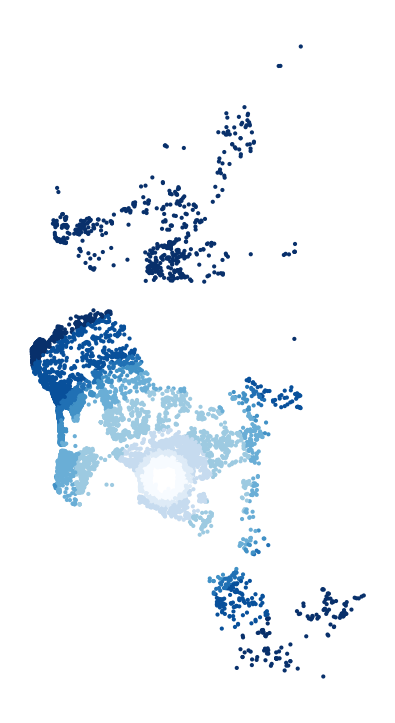

In [46]:
# Plot distance to Balboa Park
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

ax = gdf.plot(
    column="distance_to_balboa_park",
    scheme="quantiles",
    k=9,
    cmap="Blues",
    s=1,
    ax=ax
)
ax.set_axis_off()

plt.show()

# Ejercicio 4

a) Usando los datos en bank_location/addresses.txt obtener la latitud y longitud de todas las sucursales del Banco de Antigua

b) De la información obtenida en el punto a, obtener objetos del tipo Point de shapely

c) Usando el mapa de guatemala del ejercicio 1, graficar todas las sucurales en dicho mapa.

In [47]:
variables = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "has_dishwasher",
    "is_entire_place",
    "distance_to_balboa_park",
]

y = gdf["log_price"]

X = gdf[variables]

In [48]:
model_3 = spreg.OLS(
    y.values,
    X.values,
    name_y="log_price",
    name_x=variables,
)

In [49]:
print(model_3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       10592
Mean dependent var  :      5.3546                Number of Variables   :           8
S.D. dependent var  :      0.7746                Degrees of Freedom    :       10584
R-squared           :      0.5992
Adjusted R-squared  :      0.5989
Sum squared residual:      2547.3                F-statistic           :   2260.2484
Sigma-square        :       0.241                Prob(F-statistic)     :           0
S.E. of regression  :       0.491                Log likelihood        :   -7482.244
Sigma-square ML     :       0.240                Akaike info criterion :   14980.488
S.E of regression ML:      0.4904                Schwarz criterion     :   15038.630

------------------------------------------------------------

Cuando se inspecciona el modelo de regresión, se observa que esta covariable no es tan útil como se esperaba.

#### Spatial Fixed effects

Si se sabe que el precio varía en el espacio, se esperaría conocer el patrón que sigue (en este caso, por vecindario) y, por lo tanto, se puede incorporar ese conocimiento en el modelo dejando que $\alpha$ varíe en consecuencia.

Dado que sólo se incluyen unas pocas variables explicativas en el modelo, es probable que falten algunos factores importantes que influyen en la determinación del precio al que se ofrece una propiedad. Sin embargo, es probable que algunos de ellos varíen sistemáticamente en el espacio (por ejemplo, diferentes características del vecindario). Si ese es el caso, se pueden controlar esos factores no observados utilizando variables binarias tradicionales pero basando su creación en una regla espacial. Por ejemplo, si se incluye una variable binaria para cada barrio, indicando si una propiedad determinada está ubicada dentro de dicha área (`1`) o no (`0`). Matemáticamente ahora se está ajustando la siguiente ecuación:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k + \epsilon_i
$$

donde la principal diferencia es que ahora permitimos que el término constante, $\alpha$, varíe según la vecindad $r$, $\alpha_r$.

In [50]:
# spreg spatial fixed effect implementation
model_4 = spreg.OLS_Regimes(
    y=y.values,
    x=X.values,
    # Variable specifying regimes membership
    regimes=gdf["neighbourhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(variables),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    name_y="log_price",
    name_x=variables,
)

Con estos efectos fijos por vecindarios, en lugar de comparar todos los precios de las viviendas en San Diego como iguales, solo se deriva la variación dentro de cada vecindario.

Recordando que la interpretación de $\beta_k$ es el efecto de la variable $k$, *dado que todas las demás variables explicativas incluidas permanecen constantes*. Al incluir una sola variable para cada área, efectivamente se está obligando al modelo a comparar como iguales sólo los precios de las viviendas que pertenencen a la misma zona. La introducción de efectos fijos permite un mayor grado de aislamiento de los efectos de las variables que introducimos en el modelo porque podemos controlar los efectos no observados que se alinean espacialmente.

In [51]:
print(model_4.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       10592
Mean dependent var  :      5.3546                Number of Variables   :          65
S.D. dependent var  :      0.7746                Degrees of Freedom    :       10527
R-squared           :      0.6749
Adjusted R-squared  :      0.6729
Sum squared residual:     2065.97                F-statistic           :    341.4898
Sigma-square        :       0.196                Prob(F-statistic)     :           0
S.E. of regression  :       0.443                Log likelihood        :   -6373.091
Sigma-square ML     :       0.195                Akaike info criterion :   12876.182
S.E of regression ML:      0.4416                Schwarz criterion     :   13348.593

----------------------------------------

In [52]:
import contextily

In [53]:
neighbourhoods_path = DATA_PATH / "neighbourhoods.geojson"
neighbourhoods = gpd.read_file(neighbourhoods_path)
neighbourhoods.head()

,neighbourhood,neighbourhood_group,geometry
0,Amphitheater And Water Park,None,"MULTIPOLYGON (((-117.01452 32.58790, -117.0144..."
1,Bella Lago,None,"MULTIPOLYGON (((-116.94128 32.68431, -116.9412..."
2,Bonita Long Canyon,None,"MULTIPOLYGON (((-117.01149 32.66353, -117.0114..."
3,East Lake,None,"MULTIPOLYGON (((-116.99302 32.66040, -116.9816..."
4,Eastlake Trails,None,"MULTIPOLYGON (((-116.95512 32.64124, -116.9550..."


In [54]:
neighbourhoods.centroid

0      POINT (-117.00846 32.58558)
1      POINT (-116.93115 32.67696)
2      POINT (-117.00035 32.65688)
3      POINT (-116.98022 32.65581)
4      POINT (-116.94905 32.63975)
                  ...             
103    POINT (-117.21112 32.85990)
104    POINT (-117.07631 32.70295)
105    POINT (-117.09240 32.72688)
106    POINT (-117.14991 32.76025)
107    POINT (-117.24540 32.70066)
Length: 108, dtype: geometry

In [55]:
neighbourhood_effects = pd.DataFrame(
    zip(model_4.regimes_set, model_4.betas[0 : len(model_4.regimes_set)].flatten()),
    columns=["neighbourhood", "fixed_effect"],
)


In [56]:
neighbourhood_effects.head()

,neighbourhood,fixed_effect
0,Balboa Park,4.027403
1,Bay Ho,4.231940
2,Bay Park,4.299671
3,Carmel Valley,4.372030
4,City Heights East,3.919743


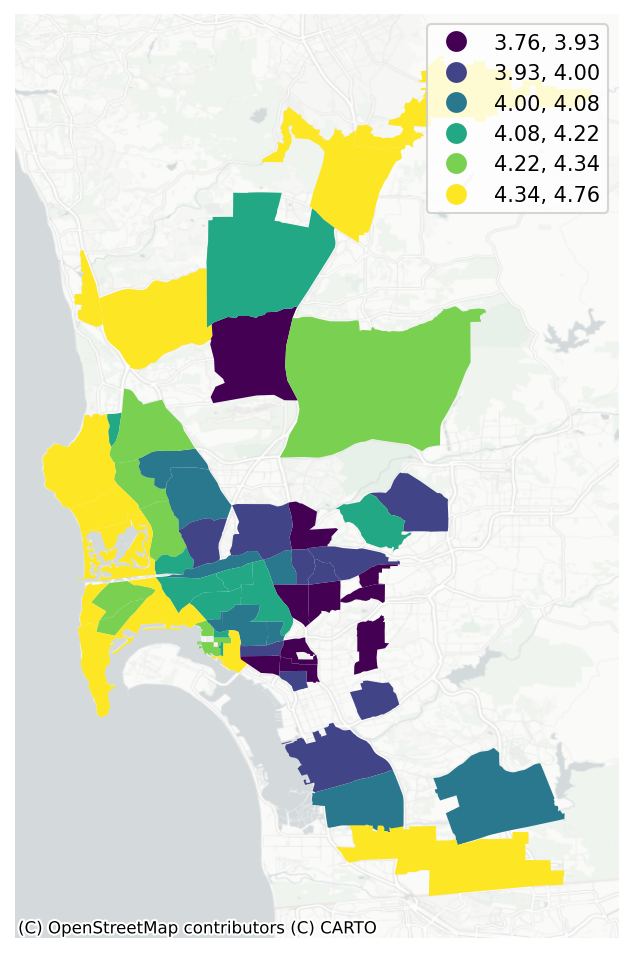

In [57]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)

neighbourhoods.merge(
    neighbourhood_effects,
    how="left",
    on="neighbourhood",
).dropna(
    subset=["fixed_effect"]
).plot(
    "fixed_effect",
    scheme="quantiles",
    k=6,
    linewidth=0.1,
    cmap="viridis",
    ax=ax,
    legend=True
)

contextily.add_basemap(
    ax,
    crs=neighbourhoods.crs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)

ax.set_axis_off()
plt.show()

### Dependencia espacial

Si se supone que el precio del alquiler de una propiedad depende de si esta rodeada por muchas propiedades que se alquilan completamente. Se podría tener la hipótesis de que si existen muchas propiedades vecinas en las que sólo se alquila una habitación el precio del alquilar de las propiedades privadas podría ser más elevado.

Es decir, se está interesado en conocer no sólo las características de cada propiedad si no también las de sus alrededores.

Este tipo de efecto espacial es fundamentalmente diferente de efectos fijos dado que no está relacionado con características inherentes de la geografía sino que se relaciona a las características de las observaciones en el conjunto de datos y, especialmente, a su
distribución espacial. Este  fenómeno por el cual los valores de las observaciones se relacionan con entre sí a través de la distancia se conoce como *dependencia espacial*.

Hay varias formas de introducir la dependencia espacial, con distintos grados de sofisticación. Sin embargo, todos ellos tienen en común la forma en que se organiza el espacio, encapsulado formalmente: a través de *spatial weights*.

### Spatial Weights

"Spatial Weights" son una forma de representar la relación de una observación con sus vecinos.

#### Basados en contigüidad

Un par contiguo de objetos espaciales son aquellos que comparten un borde común.

* **Rook**: Dos elementos son vecinos si comparten una arista.
* **Queen**: Dos elementos son vecinos si comparten un vértice.

In [58]:
from pysal.lib import weights

In [59]:
rook_weigths = weights.contiguity.Rook.from_dataframe(neighbourhoods)
queen_weigths = weights.contiguity.Queen.from_dataframe(neighbourhoods)

In [60]:
queen_weigths.neighbors

{0: [11],
 1: [17],
 2: [16, 3],
 3: [8, 17, 2, 24],
 4: [11, 5, 6, 7],
 5: [11, 4, 23],
 6: [17, 4, 13, 7],
 7: [4, 6, 24, 8, 11, 13],
 8: [17, 3, 7, 24, 13],
 9: [17],
 10: [12, 21, 22, 15],
 11: [0, 4, 5, 21, 7, 23, 15],
 12: [10, 20, 22],
 13: [8, 17, 6, 7],
 14: [41, 91, 100, 53],
 15: [16, 21, 22, 10, 11],
 16: [2, 22, 15],
 17: [1, 3, 6, 8, 9, 13],
 18: [49, 84, 104, 28, 63],
 19: [97, 52, 85, 39, 58, 44, 78],
 20: [12],
 21: [10, 11, 15],
 22: [16, 10, 12, 15],
 23: [11, 5],
 24: [8, 3, 7],
 25: [48, 98, 44],
 26: [82, 35, 103, 27, 60, 77],
 27: [64, 82, 35, 70, 26, 59],
 28: [49, 18, 84, 95],
 29: [64, 35, 71, 56, 94],
 30: [86, 87],
 31: [96, 68, 102, 87, 43, 76],
 32: [72, 105, 104, 47, 79, 63],
 33: [34, 99, 40, 105, 57, 46, 79],
 34: [33, 99, 51, 105, 75, 78, 57],
 35: [64, 77, 56, 26, 27, 29],
 36: [99, 53, 88, 41, 46, 57],
 37: [65, 42, 38, 39],
 38: [50, 37, 54, 39, 42, 44],
 39: [65, 19, 37, 38, 85, 44],
 40: [88, 33, 46, 79],
 41: [91, 36, 53, 14],
 42: [50, 37, 38, 5

#### Basados en distancia

Además de la contigüidad, también se puede definir las relaciones de vecindad como una función de la distancia que separa las observaciones espaciales. Generalmente, esto significa que se requiere una matriz que exprese las distancias entre todos los pares de observaciones. Luego, estos se proporcionan a una función **kernel** que utiliza la información de proximidad para modelar la proximidad como una función suave de la distancia.

##### K-nearest neighbors

El primer tipo de pesos basados ​​en la distancia define el conjunto vecino de una observación particular que contiene sus observaciones $k$ más cercanas, donde el usuario especifica el valor de $k$. Para ilustrar esto, se toma $k=4$.

Los centroides se calculan a partir de la información espacial almacenada en el `GeoDataFrame`. Dado que se está tratando con polígonos, "pysal" usa distancias entre centroides para determinar la $k$ observaciones más cercanas a cada polígono.

In [61]:
knn_weights = weights.distance.KNN.from_dataframe(neighbourhoods, k=4)

In [62]:
knn_weights.neighbors

{0: [21, 11, 15, 92],
 1: [17, 9, 6, 13],
 2: [3, 16, 15, 24],
 3: [24, 8, 2, 7],
 4: [5, 7, 13, 6],
 5: [4, 23, 6, 13],
 6: [13, 4, 17, 5],
 7: [4, 24, 8, 13],
 8: [24, 13, 7, 17],
 9: [17, 1, 8, 13],
 10: [22, 16, 21, 15],
 11: [7, 4, 24, 23],
 12: [20, 22, 84, 10],
 13: [6, 8, 4, 17],
 14: [53, 41, 100, 91],
 15: [16, 21, 10, 2],
 16: [15, 10, 2, 22],
 17: [9, 13, 6, 8],
 18: [104, 84, 49, 47],
 19: [39, 38, 85, 97],
 20: [83, 12, 10, 22],
 21: [15, 10, 16, 0],
 22: [10, 16, 15, 21],
 23: [5, 4, 7, 6],
 24: [8, 3, 7, 13],
 25: [48, 98, 52, 73],
 26: [77, 82, 27, 103],
 27: [59, 64, 35, 26],
 28: [95, 55, 84, 18],
 29: [64, 71, 94, 106],
 30: [90, 87, 86, 93],
 31: [76, 96, 43, 102],
 32: [105, 63, 72, 47],
 33: [99, 105, 34, 46],
 34: [33, 78, 51, 75],
 35: [77, 64, 27, 29],
 36: [41, 46, 88, 99],
 37: [42, 54, 65, 39],
 38: [39, 54, 50, 42],
 39: [38, 85, 54, 50],
 40: [46, 88, 79, 36],
 41: [36, 91, 88, 14],
 42: [54, 37, 50, 38],
 43: [76, 31, 102, 96],
 44: [50, 38, 54, 39],
 45

##### Distance bands Weights

En algunos contextos, tiene sentido trazar un círculo alrededor de cada observación y considerar como vecinas todas las demás observaciones que caen dentro del círculo. Si las observaciones están dentro, se les asigna un peso de uno en la matriz de pesos espaciales, si no, reciben un cero.

* Booleano: Los elementos dentro del radio tienen el mismo peso.
* Función de decaímiento: Se penaliza de acuerdo a la distancia.

Esto crea pesos de distancia binarios donde todas las demás observaciones dentro una distancia de 1.5 se considera vecina.

In [63]:
distance_bands_weights_binary = weights.distance.DistanceBand.from_dataframe(
    neighbourhoods, 1.5, binary=True
)

In [64]:
distance_bands_weights_binary.neighbors

{0: [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107],
 1: [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
 

In [65]:
distance_bands_weights_non_binary = weights.distance.DistanceBand.from_dataframe(
    neighbourhoods, 1.5, binary=False
)

#### Efectos exógenos: el modelo SLX

Hasta ahora se ha planteado la hipótesis de que el precio de una propiedad alquilada en San Diego a través de Airbnb se puede explicar utilizando información tanto de sus propias características como de su ubicación como el barrio o la distancia al parque principal de la ciudad. Sin embargo, también es razonable pensar que los posibles inquilinos se preocupan por el conjunto de vecinos que tiene una casa, no sólo por la casa en sí, y estarían dispuestos a pagar más por una casa que estuviera rodeada de cierto tipo de casas, y menos si estaba ubicado en medio de otros tipos. ¿Cómo se podría probar esta idea?

Cuando se trata de regresión, la forma más sencilla de introducir una dependencia espacial entre las observaciones de los datos es considerando no sólo una variable explicativa determinada, sino también su *spatial lag*.

En este caso de ejemplo, además de incluir una variable ficticia para el tipo de alquiler, también se puede incluir el spatial lag de cada tipo de alquiler. Esta suma implica que también incluimos como factor explicativo del precio de una determinada casa la proporción de propiedades vecinas de cada tipo. Matemáticamente, esto implica estimar el siguiente modelo:

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_ {j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

donde $\sum_{j=1}^N w_{ij}x_{jk}$ representa el retraso espacial de la $k$ésima variable explicativa.

Esto divide el modelo para centrarse en dos efectos principales: $\beta$ y $\gamma$. El efecto $\beta$ describe el cambio en $y_i$ cuando $X_{ik}$ cambia en uno.

El efecto $\gamma$ representa la asociación *indirecta* de un cambio en $X_i$ con el precio de la vivienda. Esto se puede conceptualizar de dos maneras.

En primer lugar, se podría pensar en $\gamma$ simplemente como *la asociación entre el precio de una propiedad determinada y un cambio unitario en su entorno promedio.*
Esto es útil y sencillo. Pero esta interpretación desdibuja *donde* este cambio
puede ocurrir.

En Python, se puede calcular el spatial lag de una variable usando la función `lag_spatial` de la librería `pysal`.

In [66]:
spatial_weights = weights.KNN.from_dataframe(gdf, k=20)
spatial_weights.weights

{0: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 1: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 2: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 3: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 4: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 5: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 6: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,


In [67]:
spatial_weights.transform = "R"

In [68]:
spatial_weights.weights

{0: [0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 1: [0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 2: [0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 3: [0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 4: [0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 5: [0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 6: [0.05,
  0.0

In [69]:
price_lag = weights.spatial_lag.lag_spatial(spatial_weights, y.values)
price_lag[0:10]

array([5.06299602, 5.52957297, 5.8612526 , 5.40607703, 5.21475944,
       5.19187896, 5.14362856, 5.12950164, 4.98542939, 5.84121472])

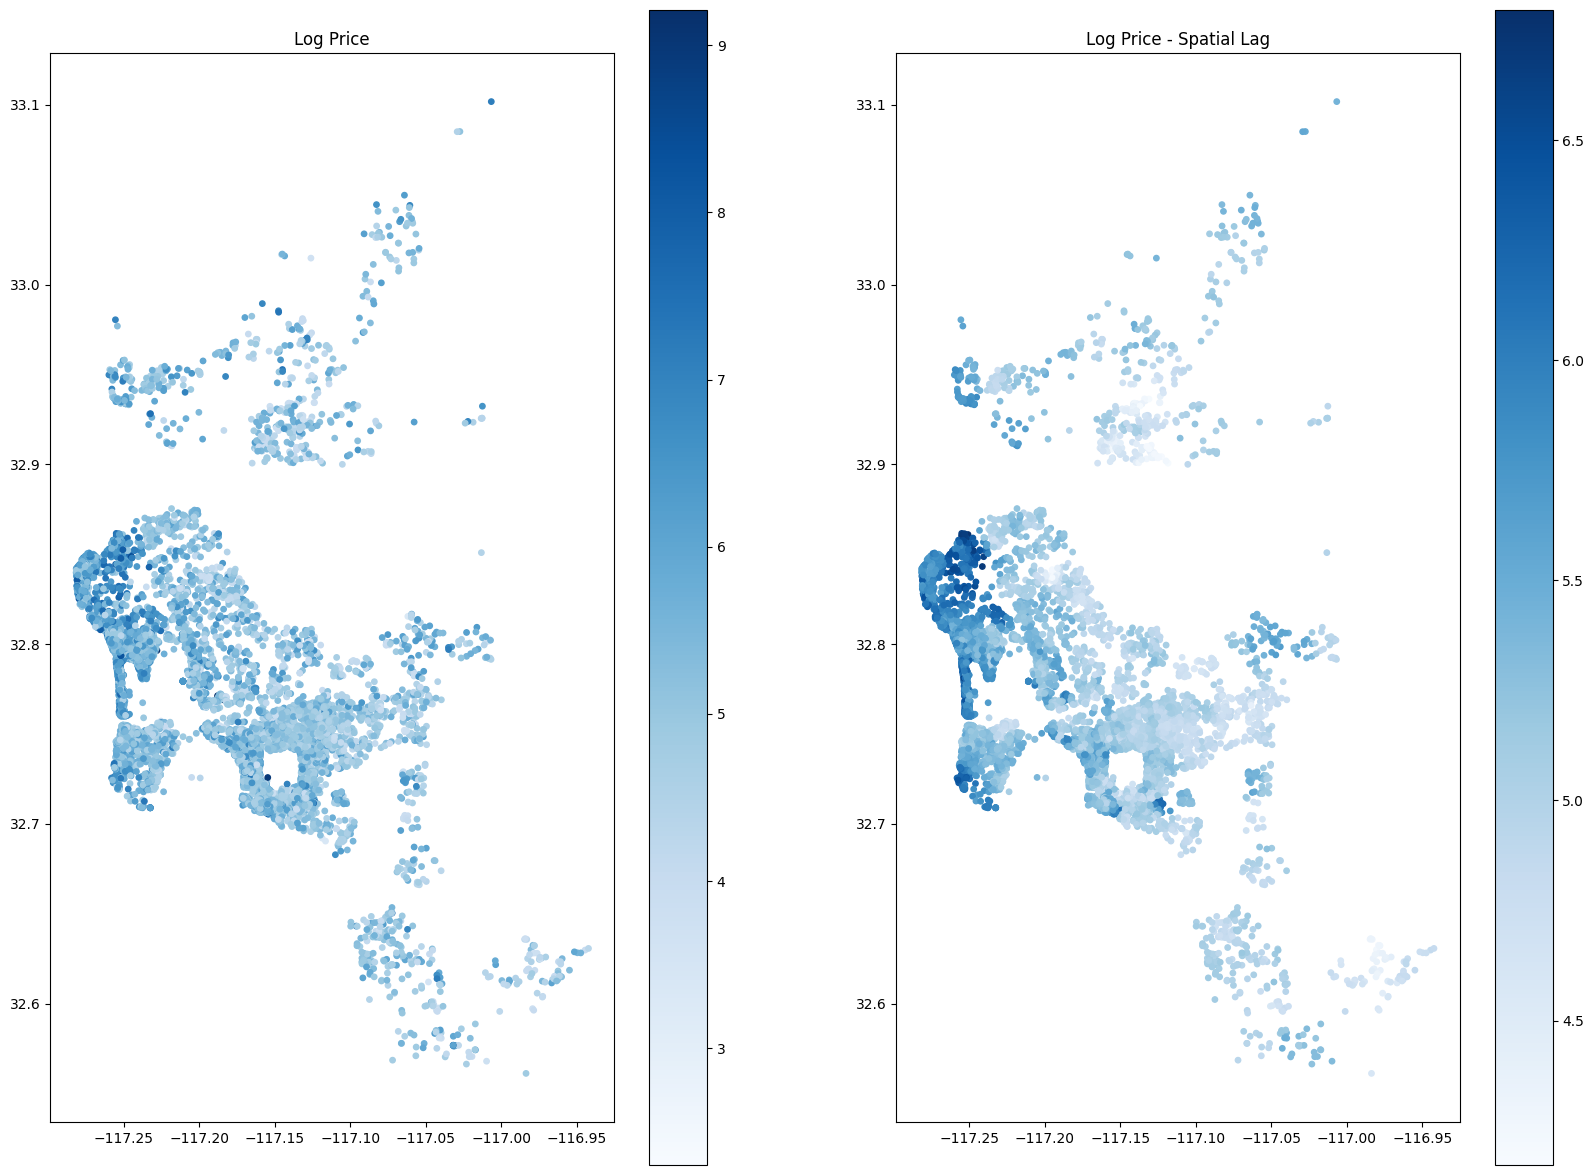

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
gdf.plot("log_price", marker=".", s=60, ax=ax1, legend=True, cmap="Blues")
gdf.plot(
    column=price_lag.flatten(), marker=".", s=60, ax=ax2, legend=True, cmap="Blues"
)
ax1.set_title("Log Price")
ax2.set_title("Log Price - Spatial Lag")
ax.set_axis_off()

plt.show()

# Ejercicio 5

Repetir el gráfico anterior con la cantidad de habitaciones

In [71]:
X["slx_is_entire_place"] = weights.spatial_lag.lag_spatial(
    spatial_weights, X["is_entire_place"]
)
X["slx_bathrooms"] = weights.spatial_lag.lag_spatial(spatial_weights, X["bathrooms"])


In [72]:
X.head()

,accommodates,bathrooms,bedrooms,beds,has_dishwasher,is_entire_place,distance_to_balboa_park,slx_is_entire_place,slx_bathrooms
0,6,2.0,3.0,3.0,1,1,3105.932563,0.95,1.425
1,6,2.0,2.0,3.0,0,1,13364.175124,0.95,1.700
2,2,1.0,2.0,6.0,1,1,14543.555447,1.00,1.875
3,2,1.0,1.0,1.0,0,1,12175.583669,0.95,2.625
4,2,1.0,0.0,0.0,0,1,11623.081360,0.75,1.450


In [73]:
slx_model = spreg.OLS(
    y=y.values,
    x=X.values,
    name_y="log_price",
    name_x=X.columns.tolist()
)

In [74]:
print(slx_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       10592
Mean dependent var  :      5.3546                Number of Variables   :          10
S.D. dependent var  :      0.7746                Degrees of Freedom    :       10582
R-squared           :      0.6249
Adjusted R-squared  :      0.6246
Sum squared residual:     2383.79                F-statistic           :   1958.8432
Sigma-square        :       0.225                Prob(F-statistic)     :           0
S.E. of regression  :       0.475                Log likelihood        :   -7130.905
Sigma-square ML     :       0.225                Akaike info criterion :   14281.809
S.E of regression ML:      0.4744                Schwarz criterion     :   14354.488

------------------------------------------------------------

##